> Modeling timing data (product trial). More specifically, we want to model how long did it take the individual t do behavior of interest. Prob want to clean this up more when I have more time. The nesting of Pareto II inside Weibull doesn't seem very clean right now. Will fix later..

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.special as sc
import os
from IPython.display import display, Image
import plotly.graph_objs as go

<div class="alert alert-block alert-info">
I actually find it easier to query Inc_trl data than cumulative trial data, which means that the input to my functions will be Week and Inc_trl.
</div>


In [81]:
def compute_probabilities(alpha, r, c, period, inc_trl):
    '''Compute the cumulative probability for each time period'''
    p = []
    for t in np.arange(len(period)):
        p.append(1 - (alpha / (alpha + period[t]**c))**r)
    return p


def log_likelihood(alpha, r, c, period, inc_trl, panel_size):
    '''Objective function that we need to maximize to 
    get best params for alpha, r, (and potentially) c'''
    if alpha <= 0 or r <= 0 or c <= 0:
        return -99999
    cumu_prob = np.array(compute_probabilities(alpha, r, c, period, inc_trl))
    
    # Compute between period probs
    probabilities = [cumu_prob[0]]
    for i in np.arange(1, len(cumu_prob)):
        probabilities.append(cumu_prob[i] - cumu_prob[i - 1])
    
    ll = np.sum(np.array(inc_trl) * np.array(np.log(probabilities))) + \
    (panel_size - np.sum(Inc_trl_list)) * np.log(1 - cumu_prob[-1])

    return ll


def maximize(period, inc_trl, panel_size, duration_dep):
    '''Maximize log-likelihood by searching 
    for best (alpha, r, c) combination'''
    if (duration_dep):
        func = lambda x: -log_likelihood(x[0], x[1], x[2], period, inc_trl, panel_size)
        x0 = np.array([100., 100., 1.])
        res = minimize(func, x0, method='Nelder-Mead', options={'xtol': 1e-8, 'disp': False})
        return res.x
    
    func = lambda x: -log_likelihood(x[0], x[1], 1, period, inc_trl, panel_size)
    x0 = np.array([100., 100.])
    res = minimize(func, x0, method='Nelder-Mead', options={'xtol': 1e-8, 'disp': False})
    return res.x


def forecast(period, inc_trl, panel_size, duration_dep, num_periods):
    '''Fits BurrXII/Pareto II and provides forecast'''
    if (duration_dep):
        alpha, r, c = maximize(period, inc_trl, panel_size, duration_dep)
        num_periods_array = np.arange(1, num_periods + 1)
        probabilities = compute_probabilities(alpha, r, c, num_periods_array, inc_trl)
        e = []
        for i in np.arange(num_periods):
            e.append(panel_size * probabilities[i])
        return e
    
    alpha, r = maximize(period, inc_trl, panel_size, duration_dep)
    num_periods_array = np.arange(1, num_periods + 1)
    probabilities = compute_probabilities(alpha, r, 1, num_periods_array, inc_trl)
    e = []
    for i in np.arange(num_periods):
        e.append(panel_size * probabilities[i])
    return e

## Example

In [19]:
data = pd.read_csv('../data/burr-XII.csv')
data['Inc_trl'] = data['# HHs'].diff()
data.at[0, 'Inc_trl'] = 8

In [21]:
data.head()

,Week,# HHs,Inc_trl
0,1,8,8.0
1,2,14,6.0
2,3,16,2.0
3,4,32,16.0
4,5,40,8.0


In [83]:
# 24-period calibration
period_list = data.Week.to_list()[:24]
inc_trl_list = data.Inc_trl.to_list()[:24]

In [84]:
# Pareto II
paretoII = forecast(period_list, inc_trl_list, 1499, False, 52)

# Weibull
weibull = forecast(period_list, inc_trl_list, 1499, True, 52)

## Plot of Results with Holdout

In [89]:
fig = go.Figure()

# Pareto II
fig.add_trace(
    go.Scatter(
        x=data.Week.to_list(),
        y=paretoII,
        mode='lines',
        name='Pareto II',
    )
)

# Weibull
fig.add_trace(
    go.Scatter(
        x=data.Week.to_list(),
        y=weibull,
        mode='lines',
        name='Weibull')
)

# Observed
fig.add_trace(
    go.Scatter(
        x=data.Week.to_list(),
        y=data['# HHs'],
        mode='lines',
        name='Actual')
)

# Plot labels
fig.update_layout(title='',
                  xaxis_title='Week',
                  yaxis_title='# HHs',
                  annotations=[      
                  ],
                )

fig.show()

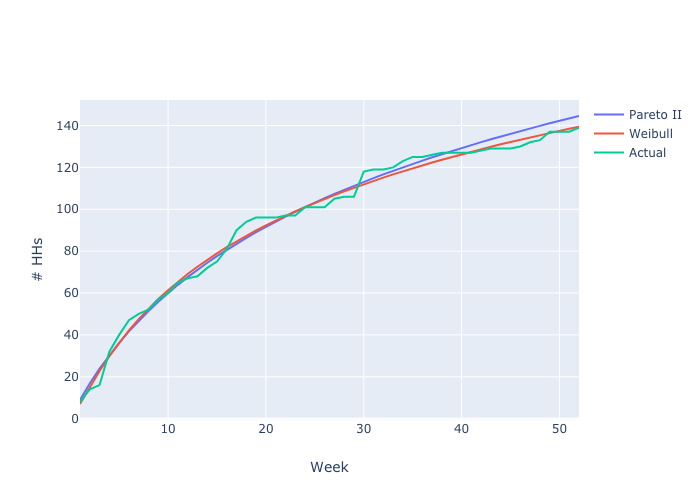

In [90]:
Image(filename='../images/BurrXII-figure-1.png')

<div class="alert alert-block alert-info">
Pretty apparent that the Pareto II tends to overforecast since it assumes no hardcore never buyers. Visually, Weibull looks to fit better.
</div>
